# Índice
1. [Introdução](#introduction)
2. [Lendo os dados](#reading)   
3. [Visão Geral](#visao)    
 3.1. [Mapas de Calor](#seaborn)
4. [Pré Processamento](#processing)   
 4.1. [Agrupamento dos dados para teste](#grouping)   
 4.1.1. [Criando nova coluna "Season"](#column-season)   
 4.2. [Criando DataFrames separados para cada estação](#dataframe-season)   
5. [SVR (Support Vector Regression)](#svr)    
    5.1. [SVR com kernel linear](#svrLinear)  
    5.2. [SVR kernel RBF](#svrRbf)   
6. [Referências](#references)

## 1. Introdução <a name="introduction"></a>
<p>Este <i>dataset</i> contém dados meteorológicos do Aeroporto Internacional de Raleigh Durham retirados do serviço da Web do NOAA.</p>

## 2. Lendo os Dados <a name="reading"></a>

In [1]:
import pandas as pd

# As colunas estão separadas pelo símbolo ';' #. 
weather_history = pd.read_csv('rdu-weather-history.csv', parse_dates=['date'], sep=';')

## 3. Visão geral <a name="visao"></a>
<p>O <i>dataset</i> contém informação sobre dados meteorológicos do Aeroporto Internacional de Raleigh Durham, desde 2007. Possui dados como temperaturas mínimas e máximas, volume de chuva, velocidade do vento e etc.</p>   
</p>Visualizando as primeiras cinco entradas do DataFrame:</p>    

In [2]:
weather_history.head()

,date,temperaturemin,temperaturemax,precipitation,snowfall,snowdepth,avgwindspeed,fastest2minwinddir,fastest2minwindspeed,fastest5secwinddir,...,drizzle,snow,freezingrain,smokehaze,thunder,highwind,hail,blowingsnow,dust,freezingfog
0,2009-10-03,55.0,82.0,0.00,0.0,0.0,2.91,240.0,16.11,230.0,...,No,No,No,No,No,No,No,No,No,No
1,2009-10-10,59.0,79.0,0.02,0.0,0.0,7.83,220.0,17.00,220.0,...,No,No,No,No,No,No,Yes,No,No,No
2,2009-10-14,46.9,61.0,0.14,0.0,0.0,8.72,40.0,14.99,50.0,...,Yes,No,No,No,No,No,Yes,No,No,No
3,2009-10-17,45.0,57.9,0.00,0.0,0.0,6.26,30.0,14.09,40.0,...,No,No,No,No,No,No,No,No,No,No
4,2009-10-29,48.0,68.0,0.00,0.0,0.0,5.82,80.0,14.99,70.0,...,No,No,No,No,No,No,No,No,No,No


In [3]:
# Número de entradas
print("Número de linhas do dataset:", weather_history.shape[0])

print("\n\nResumo estatístico do DataFrame:")
weather_history.describe()

('N\xc3\xbamero de linhas do dataset:', 4137)


Resumo estatístico do DataFrame:


,temperaturemin,temperaturemax,precipitation,snowfall,snowdepth,avgwindspeed,fastest2minwinddir,fastest2minwindspeed,fastest5secwinddir,fastest5secwindspeed
count,4136.000000,4136.000000,4136.000000,4135.000000,4136.000000,4134.000000,4135.000000,4135.000000,4118.000000,4118.000000
mean,50.540063,72.017021,0.126630,0.012965,0.017384,5.860614,172.541717,15.957151,177.056824,21.801610
std,16.229527,16.530515,0.371318,0.195214,0.213953,2.958446,94.603272,5.270319,96.850988,7.096004
min,4.100000,23.200000,0.000000,0.000000,0.000000,0.000000,10.000000,4.920000,10.000000,6.930000
25%,37.000000,60.100000,0.000000,0.000000,0.000000,3.580000,80.000000,12.970000,90.000000,17.000000
50%,52.000000,73.900000,0.000000,0.000000,0.000000,5.370000,210.000000,14.990000,210.000000,21.030000
75%,64.900000,86.000000,0.040000,0.000000,0.000000,7.610000,240.000000,18.120000,240.000000,25.050000
max,80.100000,105.100000,6.450000,6.690000,5.910000,19.010000,360.000000,59.950000,360.000000,86.120000


In [4]:
weather_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4137 entries, 0 to 4136
Data columns (total 28 columns):
date                    4137 non-null datetime64[ns]
temperaturemin          4136 non-null float64
temperaturemax          4136 non-null float64
precipitation           4136 non-null float64
snowfall                4135 non-null float64
snowdepth               4136 non-null float64
avgwindspeed            4134 non-null float64
fastest2minwinddir      4135 non-null float64
fastest2minwindspeed    4135 non-null float64
fastest5secwinddir      4118 non-null float64
fastest5secwindspeed    4118 non-null float64
fog                     4137 non-null object
fogheavy                4137 non-null object
mist                    4137 non-null object
rain                    4137 non-null object
fogground               4137 non-null object
ice                     4137 non-null object
glaze                   4137 non-null object
drizzle                 4137 non-null object
snow                

## 3.1 Utilizando a função Seaborn de mapas de calor <a name="seaborn"></a>
<p>Seaborn é uma biblioteca em python para criação de visualizações estatísticas.</p>
<p>O método ```.corr() ```, calcula o <b>coeficiente de correlação de Pearson</b> entre todos os pares de colunas numéricas do DataFrame.</p>
<p>Interpretando o coeficiente:
- 0.9 para mais ou para menos indica uma correlação muito forte.
- 0.7 a 0.9 positivo ou negativo indica uma correlação forte.
- 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
- 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
- 0 a 0.3 positivo ou negativo indica uma correlação desprezível.

In [5]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))
weather_map = sns.heatmap(weather_history.corr(), annot=True, square=True, cmap="YlGnBu", linewidths=.3)


## 4. Pré-processamento dos dados <a name="processing"></a>

In [6]:
# Substituindo as string por números binários -- No = 0.0 e Yes = 1.0

weather_history = weather_history.replace('No', 0.0)
weather_history = weather_history.replace('Yes', 1.0)

In [7]:
# Verificando a soma dos valores nulos em cada feature

weather_history.isnull().sum()

date                     0
temperaturemin           1
temperaturemax           1
precipitation            1
snowfall                 2
snowdepth                1
avgwindspeed             3
fastest2minwinddir       2
fastest2minwindspeed     2
fastest5secwinddir      19
fastest5secwindspeed    19
fog                      0
fogheavy                 0
mist                     0
rain                     0
fogground                0
ice                      0
glaze                    0
drizzle                  0
snow                     0
freezingrain             0
smokehaze                0
thunder                  0
highwind                 0
hail                     0
blowingsnow              0
dust                     0
freezingfog              0
dtype: int64

In [8]:
from sklearn.preprocessing import Imputer
import numpy as np

#Substituindo os valores nulos pela média dos valores referentes a feature
imputer = Imputer(missing_values=np.nan, strategy='median', axis=0)
weather_history[['temperaturemin']] = imputer.fit_transform(weather_history[['temperaturemin']])
weather_history[['temperaturemax']] = imputer.fit_transform(weather_history[['temperaturemax']])
weather_history[['precipitation']] = imputer.fit_transform(weather_history[['precipitation']])
weather_history[['snowfall']] = imputer.fit_transform(weather_history[['snowfall']])
weather_history[['snowdepth']] = imputer.fit_transform(weather_history[['snowdepth']])
weather_history[['avgwindspeed']] = imputer.fit_transform(weather_history[['avgwindspeed']])
weather_history[['fastest2minwinddir']] = imputer.fit_transform(weather_history[['fastest2minwinddir']])
weather_history[['fastest2minwindspeed']] = imputer.fit_transform(weather_history[['fastest2minwindspeed']])
weather_history[['fastest5secwinddir']] = imputer.fit_transform(weather_history[['fastest5secwinddir']])
weather_history[['fastest5secwindspeed']] = imputer.fit_transform(weather_history[['fastest5secwindspeed']])

weather_history.isnull().sum()

date                    0
temperaturemin          0
temperaturemax          0
precipitation           0
snowfall                0
snowdepth               0
avgwindspeed            0
fastest2minwinddir      0
fastest2minwindspeed    0
fastest5secwinddir      0
fastest5secwindspeed    0
fog                     0
fogheavy                0
mist                    0
rain                    0
fogground               0
ice                     0
glaze                   0
drizzle                 0
snow                    0
freezingrain            0
smokehaze               0
thunder                 0
highwind                0
hail                    0
blowingsnow             0
dust                    0
freezingfog             0
dtype: int64

## 4.1. Agrupamento dos dados para teste    <a name="grouping"></a>

Como o clima de uma região possui uma grande relação com as estações do ano, os dados para teste foram agrupados de acordo com a estação que occorre em uma data específica.

- Primavera: 20 de março a 20 de junho 
- Verão: 21 de junho a 21 de setembro
- Outono: 22 de setembro a 20 de dezembro
- Inverno: 21 de dezembro a 19 de março

### 4.1.1. Criando nova coluna "Season"    <a name="column-season"></a>

A coluna "season" foi criada com base nos periodos de inicio e de fim das estações do ano no local em que os dados foram colhidos.

Antes de utilizar o algoritimo para definir as estações a partir das datas é feita uma pequena alteração no formato da data.  
Antes: AAAA-MM-DD  
Depois: AAAAMMDD

In [9]:
season_array = []

for date in weather_history['date']:
    if int(date.strftime('%m%d')) >= 1221 or int(date.strftime('%m%d')) <= 319:
        season = 0 #'winter'
    elif int(date.strftime('%m%d')) >= 320 and int(date.strftime('%m%d')) <= 620:
        season = 1 #'spring'
    elif int(date.strftime('%m%d')) >= 621 and int(date.strftime('%m%d')) <= 921:
        season = 2 #'summer'
    elif int(date.strftime('%m%d')) >= 922 and int(date.strftime('%m%d')) <= 1220:
        season = 3 #'autumn'    
    
    season_array.append(season)

weather_history['season'] = season_array

In [10]:
#Ordenando o dataset pela coluna data

weather_history = weather_history.sort_values('date', ascending=True)
weather_history.head()

,date,temperaturemin,temperaturemax,precipitation,snowfall,snowdepth,avgwindspeed,fastest2minwinddir,fastest2minwindspeed,fastest5secwinddir,...,snow,freezingrain,smokehaze,thunder,highwind,hail,blowingsnow,dust,freezingfog,season
2070,2007-01-01,48.9,68.0,0.45,0.0,0.0,12.75,190.0,25.05,180.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
813,2007-01-02,32.0,55.9,0.00,0.0,0.0,3.13,320.0,12.97,330.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
814,2007-01-03,28.9,62.1,0.00,0.0,0.0,2.24,220.0,14.09,220.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
815,2007-01-04,46.0,69.1,0.00,0.0,0.0,4.47,220.0,14.09,230.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2449,2007-01-05,57.0,72.0,0.86,0.0,0.0,8.05,190.0,21.03,190.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## 4.2. Criando DataFrames separados para cada estação. <a name="dataframe-season"></a>

In [11]:
winter_weather_history = weather_history[weather_history['season'] == 0]
spring_weather_history = weather_history[weather_history['season'] == 1]
summer_weather_history = weather_history[weather_history['season'] == 2]
autumn_weather_history = weather_history[weather_history['season'] == 3]

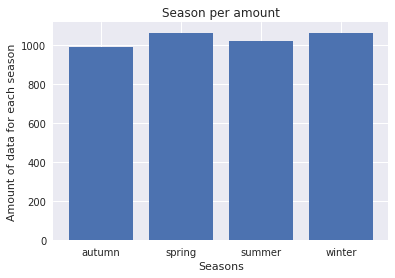

In [12]:
len_winter = len(winter_weather_history['date'])
len_summer = len(summer_weather_history['date'])
len_spring = len(spring_weather_history['date'])
len_autumn = len(autumn_weather_history['date'])

X = ['winter', 'summer', 'spring', 'autumn']
Y = [len_winter, len_summer, len_spring, len_autumn]

plt.bar(X, Y)
plt.xlabel('Seasons')
plt.ylabel('Amount of data for each season')
plt.title('Season per amount')
plt.show()

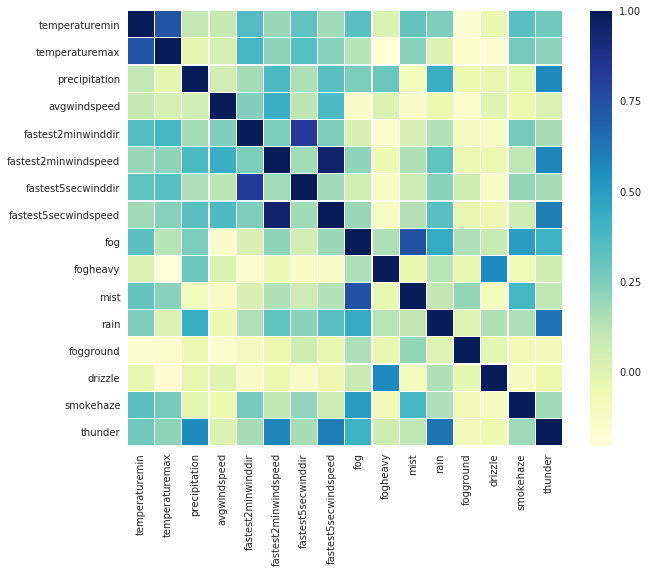

In [13]:
# Exemplo para mostrar que a correlação com a divisão do dataframe em estações aumentou. Nesse exemplo
# tem os dados do verão de 2007

plt.figure(figsize=(10,8))

summer_weather_history = summer_weather_history[summer_weather_history['date'] <= '2007-12-31']                                        
summer_weather_history = summer_weather_history.drop(columns=['snowfall', 'snowdepth', 'ice', 'glaze', 'freezingrain', 'highwind', 'hail', 'blowingsnow', 'dust', 'freezingfog', 'season', 'snow'])
sns.heatmap(summer_weather_history.corr(), square=True, cmap="YlGnBu", linewidths=.2)

## 5. SVR (Support Vector Regression)  <a name="svr"></a>  

Support Vector Regression é uma extensão do Support Vector Classification que é capaz de realizar regressões. Esse método realiza o mapeamento dos dados em um espaço multidimensional através de um mapeamento não-linear (geralmente utilizando kernels) e então realiza uma regressão linear neste espaço multidimensional transformado.

A ideia básico dos SV é a criação de hiperplanos para separar os dados.

O SVR depende apenas de um subconjunto dos dados de treinamento, porque a função custo para a construção do modelo ignora os dados de treinamento perto da previsão do modelo.

Devido ao uso dos kernel tricks, o SVR pode tratar dados pouco linearmente separáveis como linearmente sepaŕaveis através do aumento do espaço dimensional onde os dados estão inseridos.

O uso de kernel pode ser entendido através dos seguintes gráficos:

![grafico1](https://cdn-images-1.medium.com/max/1600/0*ngkO1BblQXnOTcmr.png)

Os principais parâmetros do SVR aqui utilizados são:

* Kernel: define o tipo de kernel que será utilizado (aqui serão utilizados os kernels linear e RBF)


* C (cost): define o peso de uma classificação errônea de exemplos de treinamento com relação a simplicidade da superfície de decisão. Um C baixo torna a superfície de decisão suave, enquanto um C alto tem como objetivo classificar todos os exemplos de treinamento corretamente, dando ao modelo a liberdade de selecionar mais amostras como vetores de suporte. Ou seja, o parâmetro faz o peso entre acurácia e eficácia, onde um C pequeno tende a aumentar a acurácia e um C grande tende a executar mais rapidamente.


* gamma (utilizado somente no RBF): define até onde chega a influência de um único exemplo de treinamento, com valores baixos significando "longe" e valores altos significando "perto". Basicamente um gamma muito grande causa overfitting e um gamma muito pequeno faria com que o RBF se tornasse muito parecido com um linear, já que a influência de um vetor seria muito grande.


* epsilon: é, resumidamente, a margem de erro que não é penalizado na regressão. Assim sendo, um epsilon muito grande permite que os erros não sejam penalizados, e um epsilon muito pequeno penaliza praticamente todos os erros.

Os demais ou não se adequam aos tipos de kernel (como degree e coef0) ou a variação de seus valores dentro do intervalo testado não surtiram diferenças significativas.


In [14]:
   
import matplotlib.pyplot as plt
X = weather_history.drop('temperaturemin', axis=1).values
y = weather_history['temperaturemin'].values

weather_history_no_min = weather_history.drop('temperaturemin', axis=1)

X_new = weather_history_no_min
for i in enumerate(weather_history_no_min.columns):
    related_value = weather_history_no_min[i[1]].values
    if np.array_equal(np.unique(related_value), [0, 1.]):
        X_new = X_new.drop(i[1], axis=1)

## 5.1. SVR com kernel linear <a name="svrLinear"></a>

In [15]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

X_new_new = X_new.drop('date', axis=1)
X_new_new = X_new_new.values

regr = SVR(kernel='linear', C=2.0)

X_train, X_test, y_train, y_test = train_test_split(X_new_new, y, test_size=0.25, random_state=42)
regr.fit(X_train, y_train)

SVR(C=2.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [16]:
print("\nTraining set score: {:.3f}".format(regr.score(X_train, y_train)))
print("\nTesting set score: {:.3f}".format(regr.score(X_test, y_test)))
print("\nFeatures: {}".format(np.sum(regr.coef_.shape)))


Training set score: 0.853

Testing set score: 0.855

Features: 11


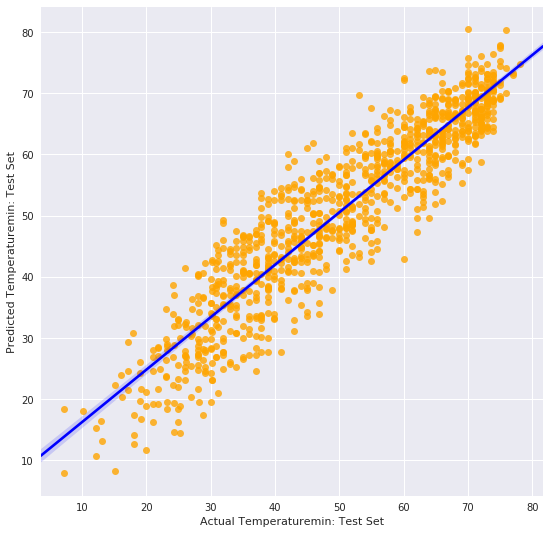

In [17]:
predict = regr.predict(X_test)
figure, axes = plt.subplots(figsize=(9, 9))
ax = sns.regplot(x = y_test, y = predict, scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
ax = ax.set(xlabel='Actual Temperaturemin: Test Set', ylabel = 'Predicted Temperaturemin: Test Set')

## Winter

In [18]:
X_winter = winter_weather_history.drop('temperaturemin', axis=1)
X_winter = X_winter.drop('date', axis=1)
X_winter = X_winter.drop('season', axis=1)
X_winter.shape

y_winter = (winter_weather_history['temperaturemin'])
y_winter.shape

# Separando o dataset em treino e teste. 30% para teste, e 70% para treinamento.
X_train, X_test, y_train, y_test = train_test_split(X_winter, y_winter, test_size = 0.3, random_state=42)

regr = SVR(kernel='linear', C=2.0)
regr.fit(X_train, y_train) 

print("\nTraining set score: {:.3f}".format(regr.score(X_train, y_train)))
print("Test set score: {:.3f}".format(regr.score(X_test, y_test)))


Training set score: 0.726
Test set score: 0.716


## Summer

In [19]:
X_summer = summer_weather_history.drop('temperaturemin', axis=1)
X_summer = X_summer.drop('date', axis=1)
X_summer.shape

y_summer = (summer_weather_history['temperaturemin'])
y_summer.shape

# Separando o dataset em treino e teste. 30% para teste, e 70% para treinamento.
X_train, X_test, y_train, y_test = train_test_split(X_summer, y_summer, test_size = 0.3, random_state=42)

regr = SVR(kernel='linear', C=2.0)
regr.fit(X_train, y_train) 

print("\nTraining set score: {:.3f}".format(regr.score(X_train, y_train)))
print("Test set score: {:.3f}".format(regr.score(X_test, y_test)))


Training set score: 0.567
Test set score: 0.606


## Spring

In [20]:
X_spring = spring_weather_history.drop('temperaturemin', axis=1)
X_spring = X_spring.drop('date', axis=1)
X_spring = X_spring.drop('season', axis=1)
X_spring.shape

y_spring = (spring_weather_history['temperaturemin'])
y_spring.shape

# Separando o dataset em treino e teste. 30% para teste, e 70% para treinamento.
X_train, X_test, y_train, y_test = train_test_split(X_spring, y_spring, test_size = 0.3, random_state=42)

regr = SVR(kernel='linear', C=2.0)
regr.fit(X_train, y_train) 

print("\nTraining set score: {:.3f}".format(regr.score(X_train, y_train)))
print("Test set score: {:.3f}".format(regr.score(X_test, y_test)))


Training set score: 0.746
Test set score: 0.727


## Autumn

In [21]:
X_autumn = autumn_weather_history.drop('temperaturemin', axis=1)
X_autumn = X_autumn.drop('date', axis=1)
X_autumn = X_autumn.drop('season', axis=1)
X_autumn.shape

y_autumn = (autumn_weather_history['temperaturemin'])
y_autumn.shape

# Separando o dataset em treino e teste. 30% para teste, e 70% para treinamento.
X_train, X_test, y_train, y_test = train_test_split(X_autumn, y_autumn, test_size = 0.3, random_state=42)

regr = SVR(kernel='linear', C=2.0)
regr.fit(X_train, y_train) 

print("\nTraining set score: {:.3f}".format(regr.score(X_train, y_train)))
print("Test set score: {:.3f}".format(regr.score(X_test, y_test)))


Training set score: 0.786
Test set score: 0.768


## 5.2. SVR kernel RBF <a name="svrRbf"></a>


Training set score: 0.627

Testing set score: 0.539


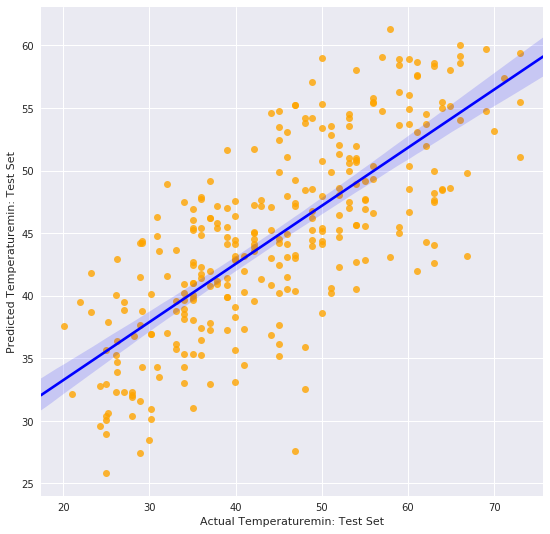

In [22]:
regrRbf = SVR(kernel='rbf', gamma=0.001, C=2.0)
regrRbf.fit(X_train, y_train)
regrRbf.score(X_train, y_train)
predictRbf = regrRbf.predict(X_test)

figure, axes = plt.subplots(figsize=(9, 9))
ax = sns.regplot(x = y_test, y = predictRbf, scatter_kws={"color": "orange"}, line_kws={"color": "blue"})
ax = ax.set(xlabel='Actual Temperaturemin: Test Set', ylabel = 'Predicted Temperaturemin: Test Set')

print("\nTraining set score: {:.3f}".format(regrRbf.score(X_train, y_train)))
print("\nTesting set score: {:.3f}".format(regrRbf.score(X_test, y_test)))

## Winter

In [23]:
X_winter = winter_weather_history.drop('temperaturemin', axis=1)
X_winter = X_winter.drop('date', axis=1)
X_winter = X_winter.drop('season', axis=1)
X_winter.shape

y_winter = (winter_weather_history['temperaturemin'])
y_winter.shape

# Separando o dataset em treino e teste. 30% para teste, e 70% para treinamento.
X_train, X_test, y_train, y_test = train_test_split(X_winter, y_winter, test_size = 0.3, random_state=42)

regrRbf = SVR(kernel='rbf', gamma=0.001, C=2.0)
regrRbf.fit(X_train, y_train) 

print("\nTraining set score: {:.3f}".format(regrRbf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(regrRbf.score(X_test, y_test)))


Training set score: 0.588
Test set score: 0.519


## Summer

In [24]:
X_summer = summer_weather_history.drop('temperaturemin', axis=1)
X_summer = X_summer.drop('date', axis=1)
X_summer.shape

y_summer = (summer_weather_history['temperaturemin'])
y_summer.shape

# Separando o dataset em treino e teste. 30% para teste, e 70% para treinamento.
X_train, X_test, y_train, y_test = train_test_split(X_summer, y_summer, test_size = 0.3, random_state=42)

regrRbf = SVR(kernel='rbf', gamma=0.001, C=2.0)
regrRbf.fit(X_train, y_train) 

print("\nTraining set score: {:.3f}".format(regrRbf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(regrRbf.score(X_test, y_test)))


Training set score: 0.350
Test set score: 0.160


## Spring

In [25]:
X_spring = spring_weather_history.drop('temperaturemin', axis=1)
X_spring = X_spring.drop('date', axis=1)
X_spring = X_spring.drop('season', axis=1)
X_spring.shape

y_spring = (spring_weather_history['temperaturemin'])
y_spring.shape

# Separando o dataset em treino e teste. 30% para teste, e 70% para treinamento.
X_train, X_test, y_train, y_test = train_test_split(X_spring, y_spring, test_size = 0.3, random_state=42)

regrRbf = SVR(kernel='rbf', gamma=0.001, C=2.0)
regrRbf.fit(X_train, y_train) 

print("\nTraining set score: {:.3f}".format(regrRbf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(regrRbf.score(X_test, y_test)))


Training set score: 0.614
Test set score: 0.566


## Autumn

In [26]:
X_autumn = autumn_weather_history.drop('temperaturemin', axis=1)
X_autumn = X_autumn.drop('date', axis=1)
X_autumn = X_autumn.drop('season', axis=1)
X_autumn.shape

y_autumn = (autumn_weather_history['temperaturemin'])
y_autumn.shape

# Separando o dataset em treino e teste. 30% para teste, e 70% para treinamento.
X_train, X_test, y_train, y_test = train_test_split(X_autumn, y_autumn, test_size = 0.3, random_state=42)

regrRbf = SVR(kernel='rbf', gamma=0.001, C=2.0)
regrRbf.fit(X_train, y_train) 

print("\nTraining set score: {:.3f}".format(regrRbf.score(X_train, y_train)))
print("Test set score: {:.3f}".format(regrRbf.score(X_test, y_test)))


Training set score: 0.627
Test set score: 0.539


## 6. Referências  <a name="references"></a>  

> [Coeficiente de correlação de Pearson](https://pt.wikipedia.org/wiki/Coeficiente_de_correla%C3%A7%C3%A3o_de_Pearson#Refer%C3%AAncias)

> [Kernel Trick](http://crsouza.com/2010/02/02/the-kernel-trick/)

> [Parâmetros do SVR](http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)